# Experiment 3

1. Create a random sat formula
* n = 10
* k = 3
* r = 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6


2. Check the number of sat clauses with the following solvers (mean over 10 times)
* Learning solver
* Learning solver with 1-sampled baseline
* Learning solver with 2-sampled baseline
* Learning solver with 3-sampled baseline

In [1]:
import torch

from src.decoders import RNNDecoder
from src.encoder_decoder import EncoderDecoder
from src.embeddings import BasicEmbedding
from src.baselines import BaselineRollout

from src.generator import UniformGenerator
from src.run_solvers import random_solver, learning_solver

import src.utils as utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

In [2]:
def run_model(formula, baseline):
    # Architecture
    cell = 'GRU'
    hidden_size = 256
    num_layers = 1
    dropout = 0
    clip_logits_c = 0 #(default: 0)

    ## Embeddings
    embedding_size = 64
    assignment_emb = BasicEmbedding(num_labels=3, embedding_size=embedding_size)
    variable_emb = BasicEmbedding(num_labels=num_variables, embedding_size=embedding_size)
    input_size = embedding_size * 2

    # Encoder
    encoder = None
    decoder = RNNDecoder(input_size = input_size,
                        cell = cell,
                        assignment_emb = assignment_emb,
                        variable_emb = variable_emb,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout,
                        clip_logits_c = clip_logits_c)
    ## Initializers
    init_dec_var = None
    init_dec_context = None
    init_dec_state = None

    ## Network
    policy_network = EncoderDecoder(encoder=encoder,
                                    decoder=decoder,
                                    init_dec_var=init_dec_var,
                                    init_dec_context=init_dec_context,
                                    init_dec_state=init_dec_state)

    # Training hyperparameters
    num_episodes = 1000
    accumulation_steps = 1
    lr = 1e-3
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    #baseline = 
    entropy_weight = 0
    clip_val = 1
    verbose = 1

    variables = None

    # num_sat, history_loss, history_num_sat
    return learning_solver(formula=formula,
                        num_variables=num_variables,
                        variables=variables,
                        encoder=encoder,
                        decoder=decoder,
                        init_dec_var=init_dec_var,
                        init_dec_context=init_dec_context,
                        init_dec_state=init_dec_state, 
                        num_episodes=num_episodes,
                        accumulation_steps=accumulation_steps,
                        lr=lr,
                        device=device,
                        baseline=baseline,
                        entropy_weight=entropy_weight,
                        clip_val=clip_val,
                        verbose=verbose)

In [3]:
experiment_name = 'exp2'
num_experiments = 10 #num of times each experiment is run

# CNF Formula
dimacs_path =  'data/uf20-91/uf20-01.cnf'
num_variables, m, formula = utils.dimacs2list(dimacs_path = dimacs_path)
n = num_variables

num_sat_rand = 0
num_sat_model = 0
history = np.array([0.0]*1000)
for _ in tqdm(range(num_experiments)):
          
    ##################################################################
    # Random solver                                                  #
    ##################################################################
    num_sat_rand += random_solver(n, formula)

    ##################################################################
    # Learning model with greedy basleine                         #
    ##################################################################
    baseline = BaselineRollout(-1)
    num_sat, history_loss, history_num_sat = run_model(formula, baseline)
    num_sat_model += num_sat
    history += np.array(history_num_sat)

num_sat_rand = num_sat_rand / num_experiments
num_sat_model = num_sat_model / num_experiments
history = history / num_experiments


 10%|█         | 1/10 [00:34<05:12, 34.77s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 83.0000


 20%|██        | 2/10 [01:10<04:41, 35.23s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 83.0000


 30%|███       | 3/10 [01:45<04:06, 35.26s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 83.0000


 40%|████      | 4/10 [02:21<03:33, 35.62s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 89.0000


 50%|█████     | 5/10 [02:57<02:58, 35.61s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 82.0000


 60%|██████    | 6/10 [03:32<02:21, 35.44s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 90.0000


 70%|███████   | 7/10 [04:07<01:46, 35.42s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 81.0000


 80%|████████  | 8/10 [04:42<01:10, 35.24s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 82.0000


 90%|█████████ | 9/10 [05:17<00:35, 35.16s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 81.0000


100%|██████████| 10/10 [05:53<00:00, 35.38s/it]

Episode [1000/1000], Mean Loss 0.0000,  Mean num sat 81.0000


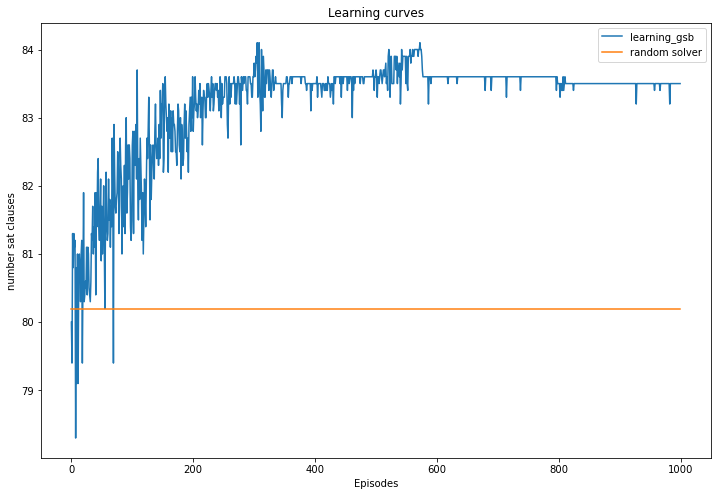

In [10]:
plt.figure(figsize=(12,8))
plt.plot(history, label='learning_gsb')
plt.plot(np.array([num_sat_rand]*1000), label='random solver')
plt.ylabel('number sat clauses')
plt.xlabel('Episodes')
plt.title('Learning curves')
#plt.grid(b=True)
plt.legend()
plt.show()

In [7]:
#Upload log_dir
#tensorboard dev upload --logdir 'outputs/exp1/runs/n20'

#from tensorboard experimental to dataframe
#https://tensorboard.dev/experiment/nGoxU6HWQMaduPCXvBpxgw/
experiment_id = 'AEfg3feBRb2gEwZmMU2FGw'
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
df

,run,tag,step,value
0,3.2,learning_1sb,0,62.0
1,3.2,learning_1sb,1,62.0
2,3.2,learning_1sb,2,59.0
3,3.2,learning_1sb,3,61.0
4,3.2,learning_1sb,4,63.0
...,...,...,...,...
235,4.6,random,75,79.0
236,4.6,random,76,76.0
237,4.6,random,77,83.0
238,4.6,random,78,78.0


In [8]:
#Save dataframe as csv
csv_path = 'csv/sip_exp2.csv'
df.to_csv(csv_path, index=False)

df = pd.read_csv(csv_path)
df

,run,tag,step,value
0,3.2,learning_1sb,0,62.0
1,3.2,learning_1sb,1,62.0
2,3.2,learning_1sb,2,59.0
3,3.2,learning_1sb,3,61.0
4,3.2,learning_1sb,4,63.0
...,...,...,...,...
235,4.6,random,75,79.0
236,4.6,random,76,76.0
237,4.6,random,77,83.0
238,4.6,random,78,78.0


Text(0.5, 1.0, 'Ratio of satisfied clauses')

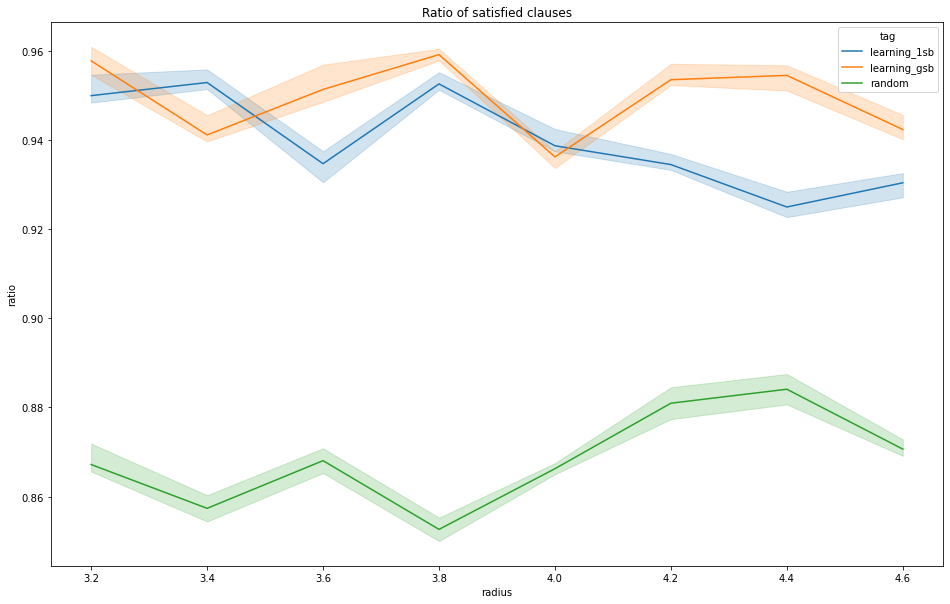

In [11]:
df2 = df.rename(columns = {'run': 'radius'}, inplace = False)

df2['ratio'] = df2['value'] * 1/(df2['radius'].astype(float) * num_variables)

plt.figure(figsize=(16, 10))
sns.lineplot(x='radius', y='ratio', hue='tag', ci=20, data=df2, estimator='mean').set_title("Ratio of satisfied clauses")